## 1.Convert raw datasets from hospital centers into usable variables to train our model
### a.Import required libraries
    

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast #package typed-ast

#Print versions
print('pandas version is :', pd.__version__)
print('numpy version is :', np.__version__)
print('wfdb version is :', wfdb.__version__)


pandas version is : 1.2.4
numpy version is : 1.20.1
wfdb version is : 3.3.0


### b.Get the datas to prepare the training phase



In [8]:
from tqdm import tqdm
def load_raw_data(df, sampling_rate, path):
    data = []
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        i=0
        for f in tqdm(df.filename_hr):
            data.append(wfdb.rdsamp(path+f))
            i+=1

    data = np.array([signal for signal, meta in data])
    return data


path = 'path/to/PTBXL'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

100%|██████████| 21837/21837 [00:59<00:00, 369.49it/s]


In [9]:
def delete_unk_ecg(x,y):
    y = list(y)
    x_processed,y_processed = [],[]
    for index,dis in enumerate(y):
        if dis != []:
            x_processed.append(x[index])
            y_processed.append(y[index])
    return x_processed,y_processed


X_train,y_train = delete_unk_ecg(X_train,y_train)
X_test,y_test = delete_unk_ecg(X_test,y_test)
            
y_train = np.array(y_train,dtype=object)
y_test = np.array(y_test,dtype=object)
X_train = np.array(X_train)
X_test = np.array(X_test)


    c. Get the shape of the input and output


In [10]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(19267,)
(19267, 5000, 12)
(2163, 5000, 12)
(2163,)


### Training with the Ribeiro NN Architecture
    a.Creating the model following this format:
![alt tag](https://user-images.githubusercontent.com/70271267/91369492-2ff41b80-e80c-11ea-9c5e-b57c6f5a9f65.png)   

As we can see the model is created by 
    
- One convolutive layer named Conv, followed by a Batch Normalization BN, and a ReLU: an activation fonction defined by: $$\forall x \in \mathbb{R},f(x) = \text{max} (x,0)$$ $$(\text{and } f(x) \ne 0 \text{ only if } x > 0)$$     

  
- A residual part made by 4 ResBlk and each one contains a chaining of a Conv + BN + ReLU and a dropout (to prevent the form the over-learning). At this point the signal is smoothed, we may have lost informations so we mix it with the non-modified signal adapted to the format by a max pooling and a 1x1 Conv. We keep this signal unchanged to use it later and we use the mixed one to continue the smoothing part, with another chainin BN/ReLU/Dropout. <br/>

- A dense part that convert the NN and permit a better prediction, combined with a sigmoïd fonction  that allows us to have prediction between 0 and 1.$$\forall x \in \mathbb{R},\sigma(x)= \dfrac{1}{1 + {\rm e}^{- x}} \text{ and easily we have } \forall x \in \mathbb{R}\, 0\le \sigma(x) \le 1  $$  
<span style="color:blue">
(Dont forget to change the input/output size before training the model)</span>.

In [4]:
#Model :
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.layers import (Input, Conv1D, MaxPooling1D, Dropout,
                          BatchNormalization, Activation, Add,
                          Flatten, Dense)
from keras.models import Model
import numpy as np


class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, otional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_rate: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_rate=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = dropout_rate
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1].value
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2].value
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


# ----- Model ----- #
kernel_size = 16
kernel_initializer = 'he_normal'
signal = Input(shape=(5000, 12), dtype=np.float32, name='signal')
age_range = Input(shape=(5,), dtype=np.float32, name='age_range')
is_male = Input(shape=(1,), dtype=np.float32, name='is_male')
x = signal
x = Conv1D(64, kernel_size, padding='same', use_bias=False,
           kernel_initializer=kernel_initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, x])
x, y = ResidualUnit(256, 196, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, y])
x, y = ResidualUnit(64, 256, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, y])
x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, y])
x = Flatten()(x)
diagn = Dense(5, activation='sigmoid', kernel_initializer=kernel_initializer)(x)
model = Model(signal, diagn)
# ----------------- #


if __name__ == "__main__":
    model.summary()

Instructions for updating:
non-resource variables are not supported in the long term
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5000, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5000, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 5000, 64)     0           batch_normalization[0][0]        
_________

    b. Convert the y_train into a usable format  
    Indeed, RIbeiro uses an output shape of (None,6) and the dataset is full of output of "[DISEASE]" so we have to convert y_train into a list of lists that contains 6 binary information : full of 0 is the patient is healthy and 1 on the good index using this format: ["maladies une par une"]

In [11]:
#Define the diseases
diseases = ["NORM","MI","HYP","CD","STTC"]

#Create a RIBEIRO format training data
def Ribeiro_convert(y_train):
    
    y_train = list(y_train)

    y_train_ = [[0,0,0,0] for i in list(y_train)]
    for index, info in enumerate(y_train):

        for disease in info:

            if disease != 'NORM':
                y_train_[index][diseases.index(disease)-1] = 1

    y_train_ = np.array(y_train_)
    return y_train_

y_train = Ribeiro_convert(y_train)
y_test = Ribeiro_convert(y_test)

print(y_train.shape)
print(y_test.shape)


##Reformat the ECG aquisition, 4048 samples needed.

(19267, 4)
(2163, 4)


    c. Train the new model

In [12]:
### Import packages 
import numpy
print('Numpy version is :',numpy.__version__)
import pandas as pd
print('Pandas version is :', pd.__version__)
import tensorflow 
print('Tenserflow version is :',tensorflow.__version__)
import scipy
print('Scipy version is :', scipy.__version__)
import sklearn 
print('Scikit-learn version is :' ,sklearn.__version__)
import tqdm 
print('tqdm version is :' ,tqdm.__version__)
import xarray 
print('xarray version is :', xarray.__version__)
import seaborn 
print('seaborn version is :',seaborn.__version__)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------

import sys     #Fait a des fonctions propres à des systèmes.
import tensorflow.compat.v1 as tf  #Fait appel à la binliothèque Tensorflow Version 1.xx
#tf.disable_v2_behavior()
from keras.optimizers import Adam #On fait appel à Adam optimizer qui est une méthode de descente de gradient stochastqiue  sur une estimation des moments du premier et second ordre
from keras.callbacks import (ModelCheckpoint,
                             TensorBoard, ReduceLROnPlateau,
                             CSVLogger, EarlyStopping)


loss = 'binary_crossentropy'
lr = 0.001
batch_size = 64
opt = Adam(lr)
callbacks = [ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=7,
                               min_lr=lr / 100),
             EarlyStopping(patience=9,  # Patience should be larger than the one in ReduceLROnPlateau
                           min_delta=0.00001)]
# Set session and compile model
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

# If you are continuing an interrupted section, uncomment line bellow:
#   model = keras.models.load_model(PATH_TO_PREV_MODEL, compile=False)
model.compile(loss=loss, optimizer=opt)



# Create log
callbacks += [TensorBoard(log_dir='./logs', batch_size=batch_size, write_graph=False),
              CSVLogger('training.log', append=False)]  # Change append to true if continuing training
# Save the BEST and LAST model
callbacks += [ModelCheckpoint('./backup_model_last.hdf5'),
              ModelCheckpoint('./backup_model_best.hdf5', save_best_only=True)]
# Train neural network

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=70,
                    initial_epoch=0,  # If you are continuing a interrupted section change here
                    validation_data = (X_test,y_test),
                    #validation_split= 0.02,
                    shuffle='batch',  # Because our dataset is an HDF5 file
                    #callbacks=callbacks,
                    verbose=1)
# Save final result
model.save("Ribeiro_model.hdf5")






Numpy version is : 1.20.1
Pandas version is : 1.2.4
Tenserflow version is : 2.4.1
Scipy version is : 1.6.2
Scikit-learn version is : 0.24.1
tqdm version is : 4.59.0
xarray version is : 0.18.0
seaborn version is : 0.11.1


NameError: name 'model' is not defined

### Using the RIBEIRO pre-trained model
####    a. Rescale the data
    Ribeiro is adaptated to 400Hz/10sec : 4096 samples, on this dataset the ECG are converted into 5000 samples array, we have to interpolate and convert array with shape (5000,) into (4096,)
    

In [13]:
import cv2 # opencv
from tqdm import tqdm
print(X.shape)#Before conversion

def convert_X(X,scale):
    X_conv = np.empty((X.shape[0], 4096, 12))
    for index,array in enumerate(X):
        array = cv2.resize(array,(12,scale))
        X_conv[index,:,:]=array
    return X_conv
    
X_=convert_X(X,4096)    
print(X_.shape)#After Conversion

(21837, 5000, 12)
(21837, 4096, 12)


#### Just to verify the interpolation, we can plot the two format, 5000 in blue and 4096 in red.

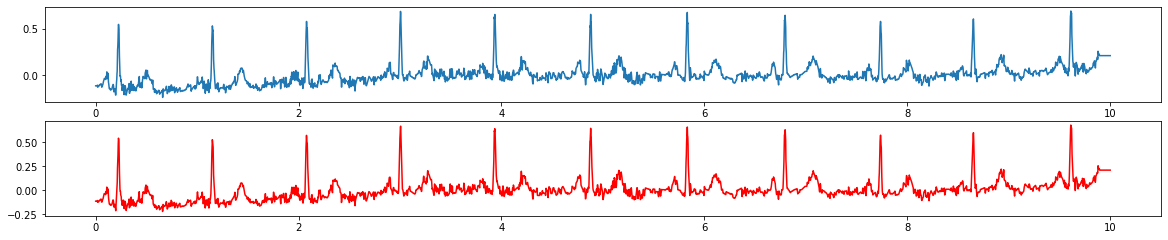

In [27]:
import numpy as np
import matplotlib.pyplot as plt
CHAR = 4096
y = np.linspace(0,10,5000)
y_ =np.linspace(0,10,CHAR)

for index,ECG_12 in enumerate(X):

        ECG_12 = np.transpose(ECG_12)
        test = plt.figure(figsize=(20,50))
        ECG_12_conv = np.transpose(X_[index])

        for n in range(12):

                plt.subplot(24,1, 2*n+1)
                plt.plot(y,ECG_12[n])

                plt.subplot(24,1,2*n+2)
                plt.plot(y_,ECG_12_conv[n],color = "r")
                break
                
        break


####  b.Import basic model

In [16]:
import tensorflow.compat.v1 as tf  #Only call the Tensorflow Version 1.xx
tf.disable_v2_behavior()
import tensorflow.keras
import keras
from keras.models import load_model
from keras.optimizers import Adam
import h5py


path_to_model = 'path/to/model'

model = load_model(path_to_model)


model.compile(loss='binary_crossentropy', optimizer=Adam())
print("Ribeiro model available")

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Ribeiro model available


### Look at the dataset to see if the healthy people are sur-represented

In [90]:
healthy = 0
for i in list(y_test)+list(y_train):
    if (i==np.array([0,0,0,0])).all():
        healthy += 1
print(healthy/(len(y_test)+len(y_train))*100,"%")

42.384507699486704 %


## Using Transfer-learning on the pre-trained model


In [17]:
### Don't take the output (6, ) part, and set trainable to False

lo = []

for layer in model.layers[1:49]:

    layer.trainable = True #False if you want to freeze the layers

    lo.append(layer.output)

    
model_adaptated = keras.Model(inputs = model.input, outputs = lo,name ='pre-trained')
model_adaptated.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=[])

model_adaptated.summary()


Model: "pre-trained"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 4096, 12)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4096, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4096, 64)     0           batch_normalization_1[0][0]      
________________________________________________________________________________________

### Plot the convoluted image after the processing part of the Neural Network
We can see that the most important arrays are contained between 100 and 250 according to the L2 Normalization.
$$\forall{x} \in \mathbb{R^{n}},\lvert x \rvert_{L2} = \sqrt{\sum_{k=1}^{n}\lvert{x}_{k}\rvert^{2}} $$


Mean is 165
Median is 203


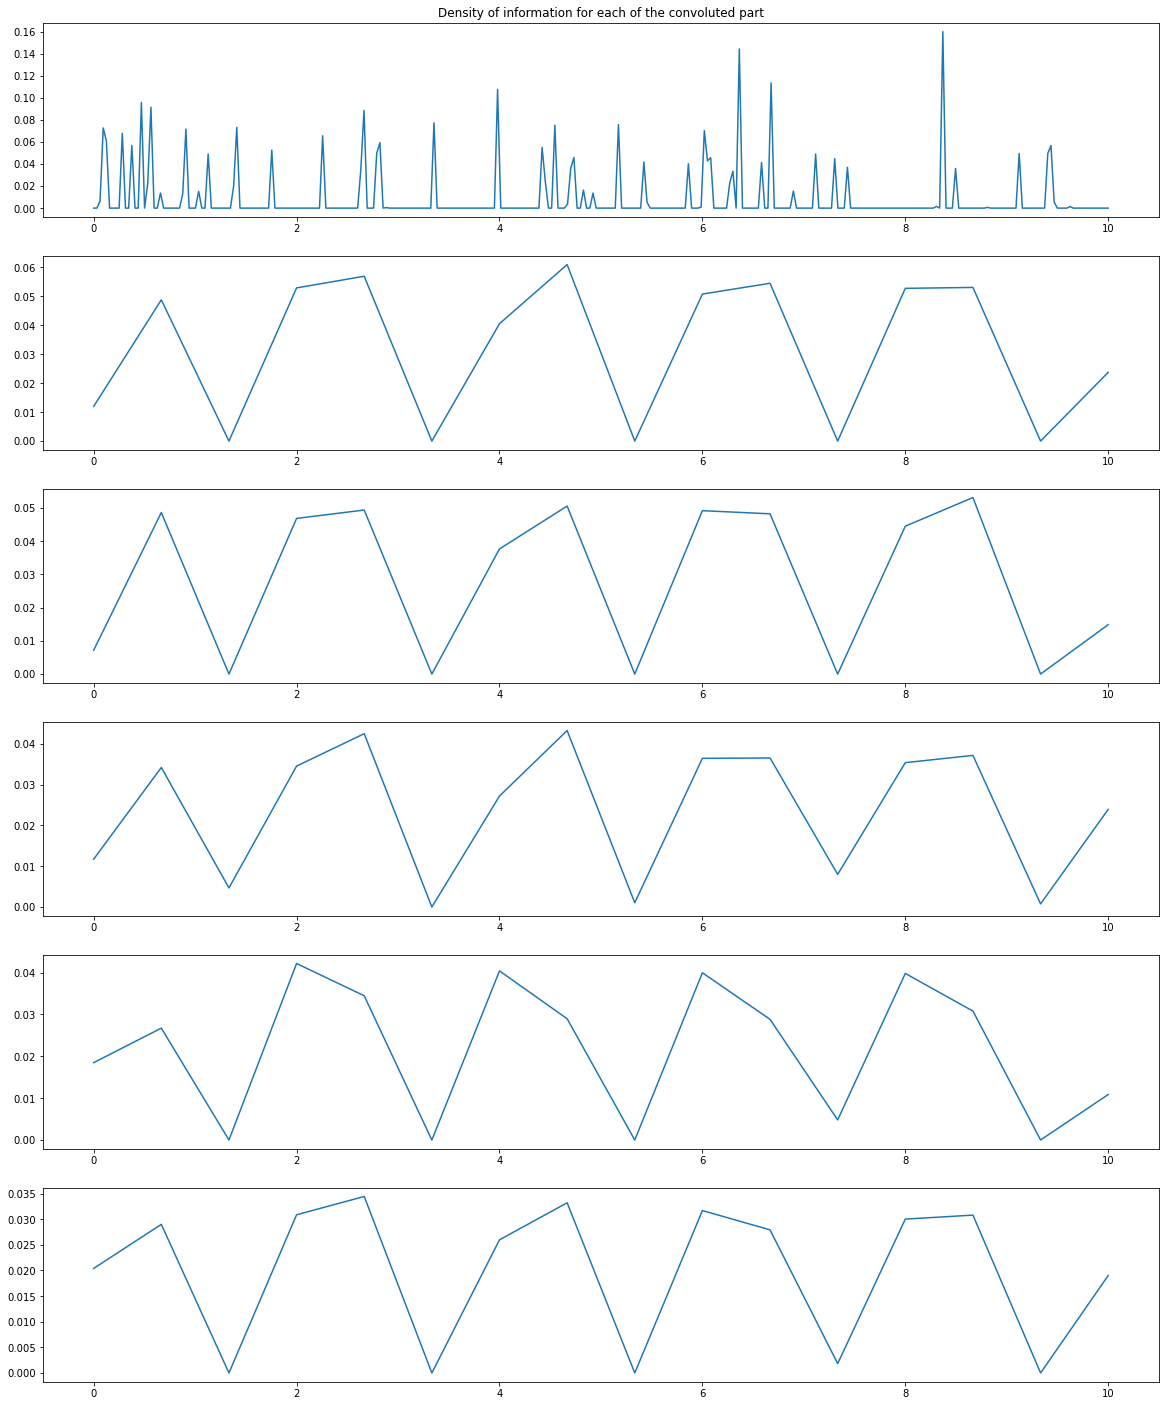

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

conv_example = model_adaptated.predict(np.array([X_[0]]))[-2] #We do not want the flattened part, only the convoluated array before

y = np.linspace(0,10,16)


ECG_12 = np.transpose(conv_example)

infos = [np.linalg.norm(x) for x in ECG_12]
infos_2 = infos.copy()
max_L2 = [infos.pop(infos.index(max(infos))) for i in range(5)]  #Looking only the most important arrays, with the biggest L2 norm.

infos_max = [infos_2.index(i) for i in max_L2]

fig = plt.figure(figsize=(20,25))
y_l2=np.linspace(0,10,320)
plt.subplot(6,1,1)
plt.plot(y_l2,infos_2)
plt.title("Density of information for each of the convoluted part")
print(f"Mean is {statistics.mean(infos_max)}")
print(f"Median is {statistics.median(infos_max)}")
for i,n in enumerate(infos_max):
        
        plt.subplot(6,1,i+2)
        plt.plot(y,ECG_12[n])



### Adding our own trainable model to fit at those new diseases

In [18]:
from keras.layers import (Input, Conv1D, MaxPooling1D, Dropout,
                          BatchNormalization, Activation, Add,
                          Flatten, Dense)
from keras.utils import plot_model
#plot_model(model_adaptated, to_file='model.png', show_shapes=True)

kernel_initializer = 'he_normal'
x = model_adaptated.output[47]
#x = Dense(5120, activation = 'relu',name = 'First_dense')(x)
#x = Dense(5120, activation = 'relu',name = 'Second_dense')(x)
preds = Dense(4,activation='sigmoid', kernel_initializer=kernel_initializer)(x)

new_model = keras.Model(inputs = model_adaptated.input, outputs = preds)
new_model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 4096, 12)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4096, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4096, 64)     0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

### Train the new part

In [19]:
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from datetime import datetime
import time 

CHAR = 4096
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
date_time = str(now.day)+"-"+ str(current_time) 

NAME = "New_Ribeiro_model_fulltrained" + date_time #To analyse easily on TensorBoard
beginning = time.time()
X_train = convert_X(X_train,CHAR)
X_test = convert_X(X_test,CHAR)

#Prevent from overfitting
monitor = EarlyStopping(monitor ='val_loss',
                        min_delta=0.001,
                        patience=20,
                        verbose=0,
                        restore_best_weights=True)

tensorboard = TensorBoard(log_dir = "logs/"+ NAME,histogram_freq=2)
batch_size = 64
history = new_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    validation_data = (X_test,y_test),
                    verbose=1,
                    callbacks = [monitor,tensorboard])

# Save final result
new_model.save(NAME + ".hdf5")
#1st try = 0.64
#2nd = 0.68
#3rd = 0.6

Train on 19267 samples, validate on 2163 samples


/home/cotxetjordi/anaconda3/envs/ECG_all/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1/50
19267/19267 [==============================] - 2336s 121ms/sample - loss: 0.4314 - auc: 0.7750 - precision: 0.6699 - recall: 0.1138 - val_loss: 0.4116 - val_auc: 0.8388 - val_precision: 0.7576 - val_recall: 0.2177
Epoch 2/50
19267/19267 [==============================] - 2065s 107ms/sample - loss: 0.3344 - auc: 0.8827 - precision: 0.7390 - recall: 0.4712 - val_loss: 0.3530 - val_auc: 0.8851 - val_precision: 0.8200 - val_recall: 0.4290
Epoch 3/50
19267/19267 [==============================] - 2329s 121ms/sample - loss: 0.3016 - auc: 0.9052 - precision: 0.7734 - recall: 0.5786 - val_loss: 0.3425 - val_auc: 0.8940 - val_precision: 0.7984 - val_recall: 0.4850
Epoch 4/50
19267/19267 [==============================] - 2062s 107ms/sample - loss: 0.2890 - auc: 0.9129 - precision: 0.7804 - recall: 0.6052 - val_loss: 0.3410 - val_auc: 0.8968 - val_precision: 0.8177 - val_recall: 0.4981
Epoch 5/50
19267/19267 [==============================] - 2330s 121ms/sample - loss: 0.2799 - auc: 0

###  Predict

In [ ]:

modelzz = load_model("New_Ribeiro_model_3layers_4-09:49:05.hdf5")

print('model loaded')
y_predicted = modelzz.predict(X_test,verbose=1)


model loaded


/home/cotxetjordi/anaconda3/envs/ECG_all/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Find the tresholds

In [21]:
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score)

def get_optimal_precision_recall(y_true, y_score):
    """Find precision and recall values that maximize f1 score."""
    n = np.shape(y_true)[1]
    opt_precision = []
    opt_recall = []
    opt_threshold = []
    for k in range(n):
        # Get precision-recall curve
        precision, recall, threshold = precision_recall_curve(y_true[:, k], y_score[:, k])
        # Compute f1 score for each point (use nan_to_num to avoid nans messing up the results)
        f1_score = np.nan_to_num(2 * precision * recall / (precision + recall))
        # Select threshold that maximize f1 score
        index = np.argmax(f1_score)
        opt_precision.append(precision[index])
        opt_recall.append(recall[index])
        t = threshold[index-1] if index != 0 else threshold[0]-1e-10
        opt_threshold.append(t)

    return np.array(opt_precision), np.array(opt_recall), np.array(opt_threshold)

p,r,t = get_optimal_precision_recall(y_test.astype(float),y_predicted)
print("precision:",p)
print("recall:",r)
print('thresholds:',t)



precision: [0.73977087 0.59090909 0.82678984 0.74605954]
recall: [0.81735986 0.69201521 0.7188755  0.81453155]
thresholds: [0.5509228  0.24898255 0.40516484 0.20714024]


### Convert our predictions into one hot encoding

In [22]:
import tqdm
y_score = []
thresholds = t


for pred in tqdm.tqdm(y_predicted):
    res = [0,0,0,0]
    for ind,val in enumerate(pred):

        if val > thresholds[ind]:
           
            res[ind] = 1 

    y_score.append(res)

100%|██████████| 2163/2163 [00:00<00:00, 254239.42it/s]


### Determine prediction Total stats and sensitivity

In [41]:
import statistics
pos = 0
failed_prec = []
sensi =  0
failed_sensi = []
nb_fail = 0


for i in range(len(y_score)):
    
    if not (y_test[i] == y_score[i]).all(): 
        failed_prec.append(i)
        nb_fail += 1 
    for index,o in enumerate(y_score[i]):
        if o != y_test[i,index]:
            sensi +=1
print(f"total binary accuraracy is {(1-sensi/(len(y_score)*4))*100} %")
print(f"Total precision is {(1-nb_fail/len(y_score))*100}","%")
print(f"Total recall is {statistics.mean(r)*100}","%") # approximately equal proportions of each diseases

total binary accuraracy is 89.32038834951457 %
Total precision is 65.46463245492372 %
Total recall is 76.06955288063041 %
